# Creating Carbon Dioxide Removal (CDR) Forcing

`ROMS-Tools` provides two distinct classes for implementing Carbon Dioxide Removal (CDR) forcing:

- **CDRVolumePointSource**  
  Represents point sources that inject both water and biogeochemical (BGC) tracers at specified locations—such as through an underwater pipe.

  - Designed for field-scale deployments where localized mixing is critical.  
  - Introduces both volume flux and tracer concentrations at fixed points.  
  - Requires all 32 MARBL BGC tracers, as well as temperature and salinity (defaults are provided if not specified).

- **CDRTracerPerturbation**  
  Applies tracer-only perturbations to existing BGC fields without introducing any water (i.e., no volume flux).

  - Intended for large-scale simulations where small-scale mixing processes are implicitly represented.  
  - Only the specified tracers are altered; all others remain unchanged.

This notebook demonstrates how to configure and apply both CDR forcing types using `ROMS-Tools`.

In [1]:
from roms_tools import Grid
from datetime import datetime

Let's create our CDR forcings for the following grid spanning the Nordic Seas.

In [2]:
grid = Grid(
    nx=250,
    ny=250,
    size_x=2500,
    size_y=2500,
    center_lon=-15,
    center_lat=65,
    rot=-30,
    N=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

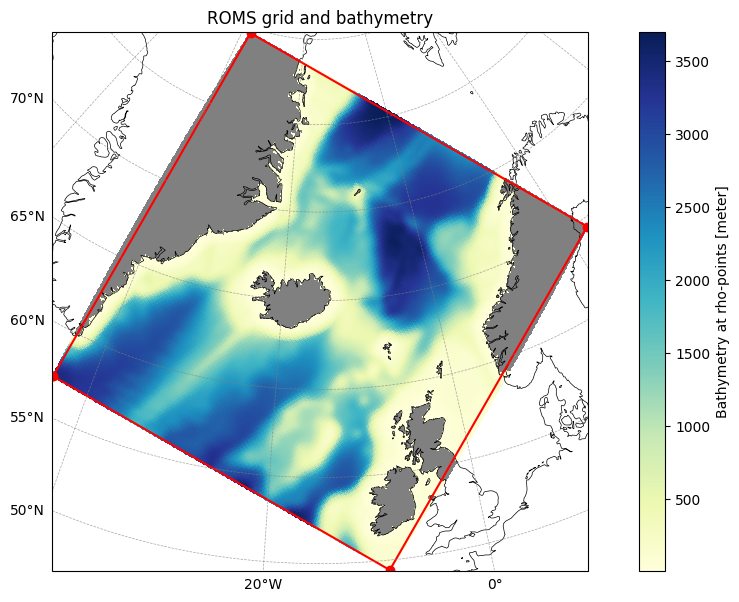

In [3]:
grid.plot()

## CDR Volume Point Sources

In this section, we walk through how to configure and use the `CDRVolumePointSource` class to represent localized injections of water and tracers in a ROMS simulation.

In [4]:
from roms_tools import CDRVolumePointSource

First, specify the start and end times of the intended ROMS simulation.

In [5]:
cdr_forcing = CDRVolumePointSource(
    grid=grid, start_time=datetime(2010, 1, 1), end_time=datetime(2012, 1, 1)
)

### Release Tracking

There are two key places where releases are tracked:

- `.ds` attribute: This holds an xarray `Dataset` with the release information. This dataset can eventually be saved to a NetCDF file, providing the ROMS input file.  
- `.releases` attribute: This holds a dictionary containing the release information (also stored in `.ds`), but in a human-readable format. The dictionary can be saved and loaded from a YAML file, ensuring reproducibility.

Since no releases have been added yet, the `.ds` attribute currently contains an empty dataset with zero release entries. The `ncdr` dimension tracks the number of releases, which is currently set to zero.

In [6]:
cdr_forcing.ds

<xarray.Dataset> Size: 9kB
Dimensions:           (time: 0, ncdr: 0, ntracers: 34)
Coordinates:
  * time              (time) float64 0B 
    release_name      (ncdr) <U1 0B 
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
Dimensions without coordinates: ncdr, ntracers
Data variables:
    cdr_time          (time) float64 0B 
    cdr_lon           (ncdr) float64 0B 
    cdr_lat           (ncdr) float64 0B 
    cdr_dep           (ncdr) float64 0B 
    cdr_hsc           (ncdr) float64 0B 
    cdr_vsc           (ncdr) float64 0B 
    cdr_volume        (time, ncdr) float64 0B 
    cdr_tracer        (time, ntracers, ncdr) float64 0B

Similarly, the `.releases` dictionary contains no actual releases, only metadata that specifies the units expected for the tracer concentrations.

In [7]:
cdr_forcing.releases

{'_tracer_metadata': {'temp': {'units': 'degrees Celsius',
   'long_name': 'potential temperature'},
  'salt': {'units': 'PSU', 'long_name': 'salinity'},
  'PO4': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic phosphate'},
  'NO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic nitrate'},
  'SiO3': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic silicate'},
  'NH4': {'units': 'mmol/m^3', 'long_name': 'dissolved ammonia'},
  'Fe': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic iron'},
  'Lig': {'units': 'mmol/m^3', 'long_name': 'iron binding ligand'},
  'O2': {'units': 'mmol/m^3', 'long_name': 'dissolved oxygen'},
  'DIC': {'units': 'mmol/m^3', 'long_name': 'dissolved inorganic carbon'},
  'DIC_ALT_CO2': {'units': 'mmol/m^3',
   'long_name': 'dissolved inorganic carbon, alternative CO2'},
  'ALK': {'units': 'meq/m^3', 'long_name': 'alkalinity'},
  'ALK_ALT_CO2': {'units': 'meq/m^3',
   'long_name': 'alkalinity, alternative CO2'},
  'DOC': {'units': 'mm

As we add releases in the subsequent steps, both the `.ds` and `.releases` attributes will be populated with additional entries.

### Plotting Release Locations

In the following sections, we will add releases to the `CDRVolumePointSource` object that we created earlier. For each of these releases, we can visualize its location. 

To start, we'll use three simple dummy releases (with zero volume flux, and therefore zero tracers). This will help us explore how release locations are plotted before progressing to more complex release scenarios later on.

In [8]:
cdr_forcing.add_release(
    name="release_Iceland",
    lat=65.0,  # degree N
    lon=-25,  # degree E
    depth=10,  # m
    volume_fluxes=0,
)

cdr_forcing.add_release(
    name="release_Greenland", lat=70.0, lon=-20.0, depth=100, volume_fluxes=0
)

cdr_forcing.add_release(
    name="release_Norway", lat=65.0, lon=10, depth=50, volume_fluxes=0
)

First, we will plot the release location from a bird's-eye view.

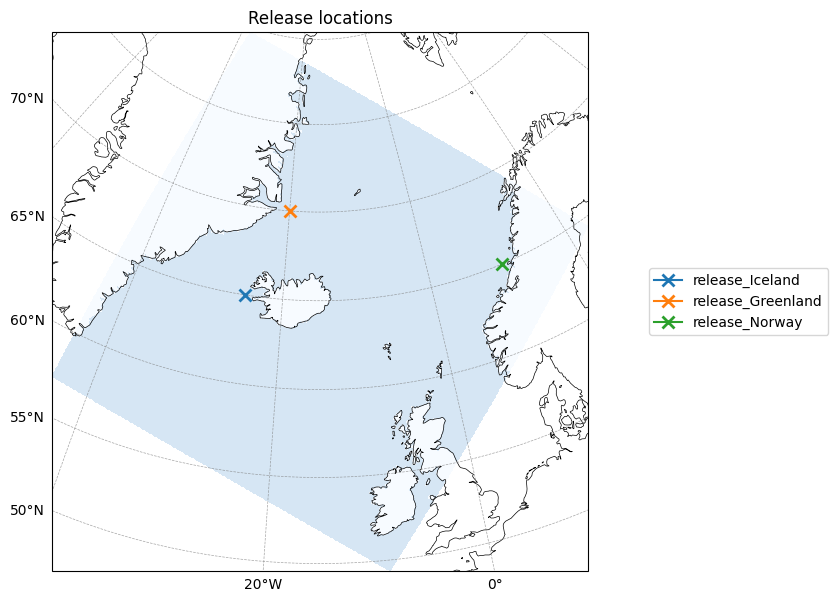

In [9]:
cdr_forcing.plot_location_top_view()  # By default, this plots all available release locations.

We can also restrict the plot to display only the releases of interest by specifying them in a list via the `releases` parameter.

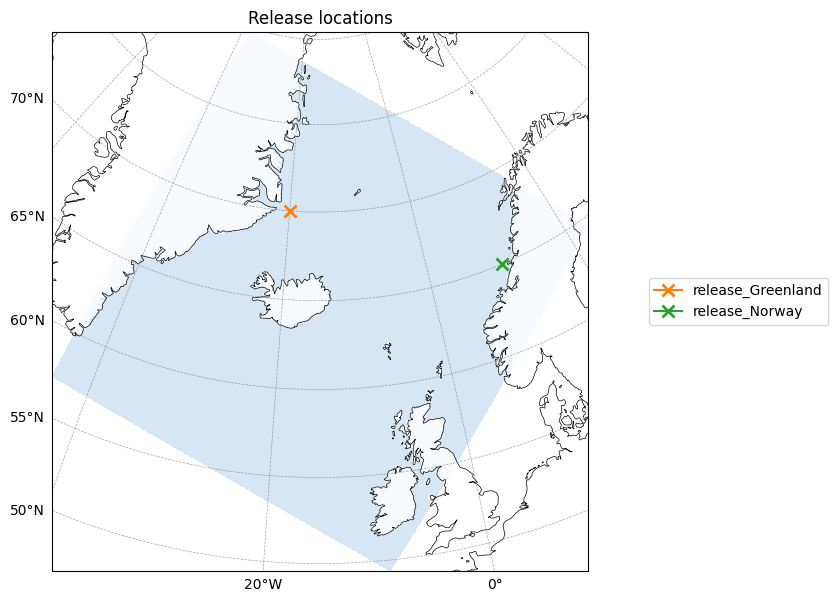

In [10]:
cdr_forcing.plot_location_top_view(releases=["release_Greenland", "release_Norway"])

Next, we plot the release locations from a side view. Note that we can only plot one release at a time in this view, as the latitude and longitude section to be visualized depends on the specific location of the release itself.

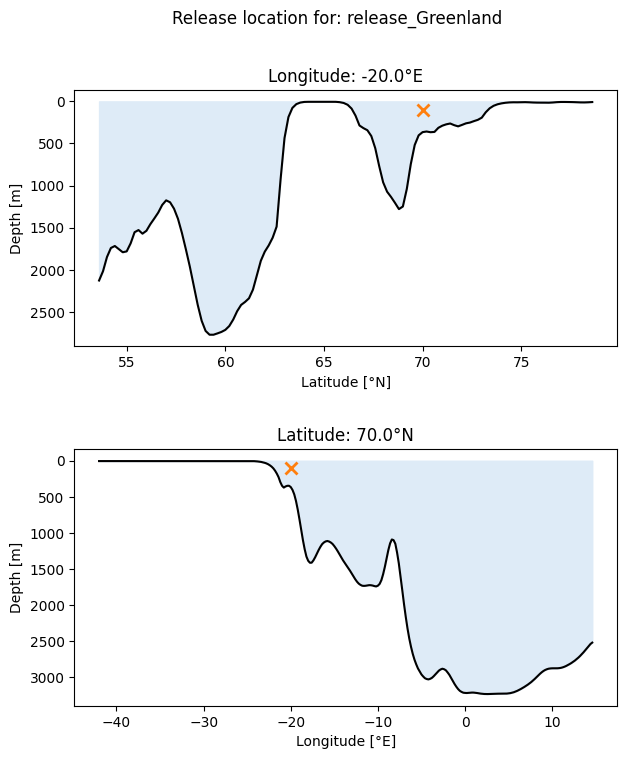

In [11]:
cdr_forcing.plot_location_side_view(release="release_Greenland")

### Adding a constant release over the full simulation period

The three dummy releases from the previous section won't affect the ROMS simulation because we set the volume flux to zero, which results in zero tracer addition.

Now, let's start fresh and proceed with a more meaningful example.

In [12]:
cdr_forcing = CDRVolumePointSource(
    grid=grid, start_time=datetime(2010, 1, 1), end_time=datetime(2012, 1, 1)
)

Let's introduce a constant volume flux and tracer concentrations that will remain fixed over time and have a real impact on the simulation:

* Volume flux: 1000 m³/s
* Temperature: 20°C
* Salinity: 1 psu
* Alkalinity: 2000 meq/m³

These constant values will be applied over the entire simulation period.

In [13]:
cdr_forcing.add_release(
    name="Iceland_field_trial",
    lat=65.0,
    lon=-25,
    depth=10,
    volume_fluxes=1000,  # m³/s
    tracer_concentrations={
        "temp": 20.0,
        "salt": 1.0,
        "ALK": 2000.0,
    },  # for units consult cdr_forcing.releases["_tracer_metadata"]
)

The release has now been successfully recorded in the `.ds` attribute.

In [14]:
cdr_forcing.ds

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 2, ntracers: 34, ncdr: 1)
Coordinates:
  * time              (time) datetime64[ns] 16B 2010-01-01 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U19 76B 'Iceland_field_trial'
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 16B 3.653e+03 4.383e+03
    cdr_lon           (ncdr) float64 8B -25.0
    cdr_lat           (ncdr) float64 8B 65.0
    cdr_dep           (ncdr) float64 8B 10.0
    cdr_hsc           (ncdr) float64 8B 0.0
    cdr_vsc           (ncdr) float64 8B 0.0
    cdr_volume        (time, ncdr) float64 16B 1e+03 1e+03
    cdr_tracer        (time, ntracers, ncdr) float64 544B 20.0 1.0 ... 1.5e-06

To visualize the data in the dataset, we can use the `.plot_volume_flux` and `.plot_tracer_concentration` methods.

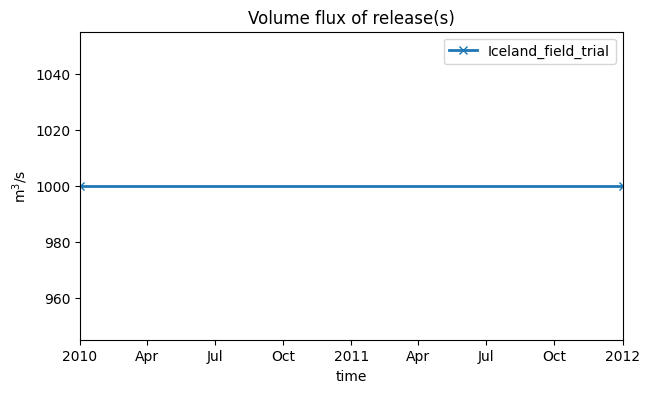

In [15]:
cdr_forcing.plot_volume_flux()

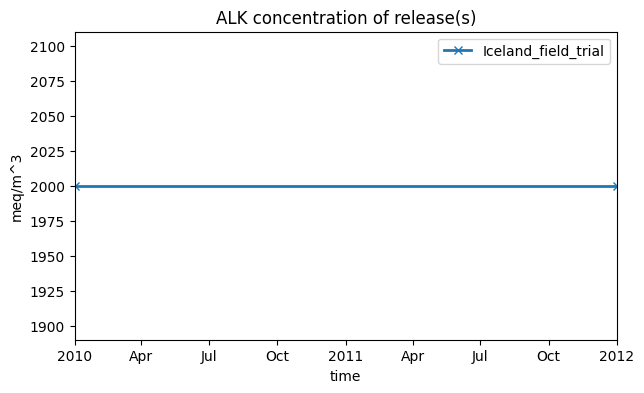

In [16]:
cdr_forcing.plot_tracer_concentration("ALK")

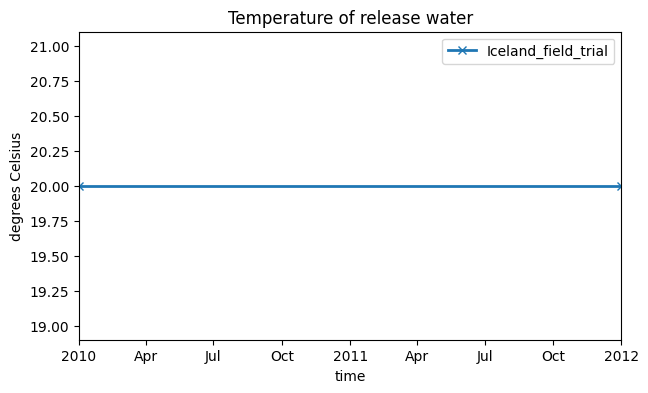

In [17]:
cdr_forcing.plot_tracer_concentration("temp")

The three plots above confirm that the specified values for the volume flux and tracer concentrations are consistently applied and remain constant throughout the entire simulation period.

### Adding time-varying releases

Next, we will add a time-varying release. To do this, we need to specify the `times` parameter, which defines the explicit time points for the volume fluxes and tracer concentrations.

In the following example, we specify time-varying volume fluxes and time-varying alkalinity concentrations (provided as lists, where the length of each list must match the length of the `times` list), while keeping the temperature and salinity constant throughout the simulation (specified as constant values rather than lists).

In [18]:
greenland_params = {"lat": 70, "lon": -20, "depth": 100}

In [19]:
cdr_forcing.add_release(
    name="Greenland_field_trial",
    **greenland_params,
    times=[
        datetime(2011, 1, 15, 12, 0),
        datetime(2011, 1, 15, 15, 0),
        datetime(2011, 1, 15, 18, 0),
        datetime(2011, 1, 15, 21, 0),
        datetime(2011, 1, 22, 3, 0),
        datetime(2011, 1, 22, 6, 0),
        datetime(2011, 1, 22, 9, 0),
        datetime(2011, 1, 22, 12, 0),
    ],
    volume_fluxes=[0, 100, 500, 1000, 1000, 500, 100, 0],
    tracer_concentrations={
        "ALK": [
            2000.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2000.0,
        ],
        "temp": 20.0,
        "salt": 1.0,
    },
)

The next two figures confirm that both the volume flux and alkalinity concentrations are correctly time-varying, as specified, and match the expected behavior.

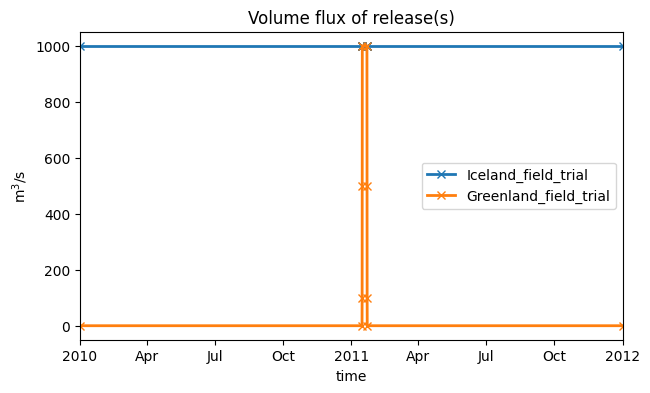

In [20]:
cdr_forcing.plot_volume_flux()

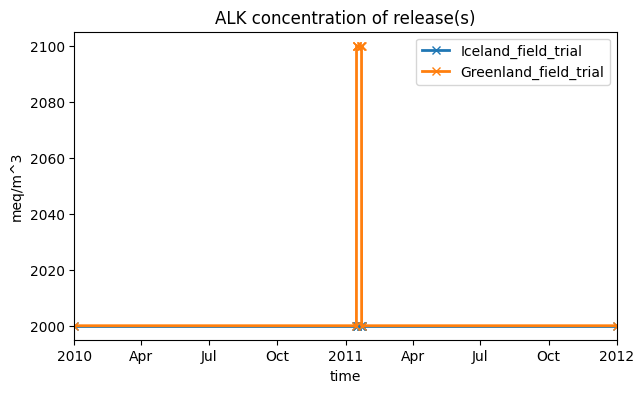

In [21]:
cdr_forcing.plot_tracer_concentration("ALK")

Let's now zoom into the specific time window where the release occurs to better visualize the time-varying behavior of the volume flux and tracer concentrations.

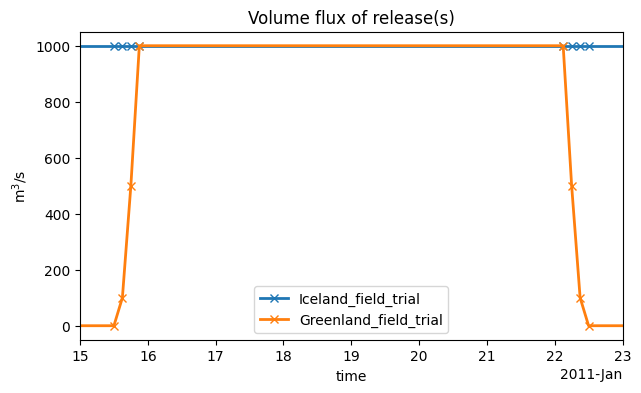

In [22]:
cdr_forcing.plot_volume_flux(start=datetime(2011, 1, 15), end=datetime(2011, 1, 23))

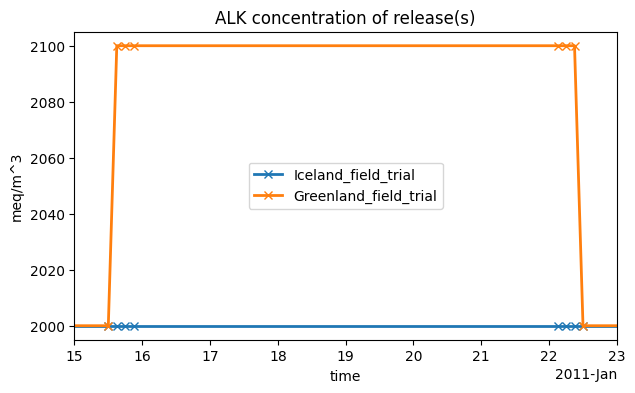

In [23]:
cdr_forcing.plot_tracer_concentration(
    "ALK", start=datetime(2011, 1, 15), end=datetime(2011, 1, 23)
)

In the next example, we define a release similar to the previous one, but this time, we omit the two endpoints of the `times` array, where the volume flux is set to zero.

In [24]:
cdr_forcing.add_release(
    name="another_Greenland_field_trial",
    **greenland_params,
    times=[
        datetime(2011, 1, 15, 15, 0),
        datetime(2011, 1, 15, 18, 0),
        datetime(2011, 1, 15, 21, 0),
        datetime(2011, 1, 22, 3, 0),
        datetime(2011, 1, 22, 6, 0),
        datetime(2011, 1, 22, 9, 0),
    ],
    volume_fluxes=[
        100,
        500,
        1000,
        1000,
        500,
        100,
    ],
    tracer_concentrations={
        "ALK": [
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
            2100.0,
        ],
        "temp": 20.0,
        "salt": 1.0,
    },
)

Let's now compare the time series of volume flux and alkalinity concentration for the two Greenland field trial releases.

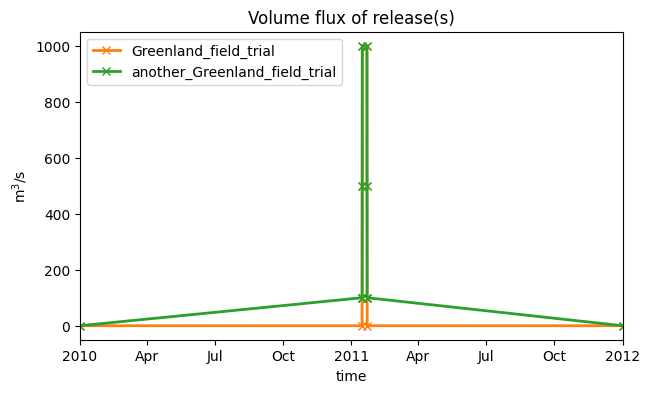

In [25]:
cdr_forcing.plot_volume_flux(
    releases=["Greenland_field_trial", "another_Greenland_field_trial"]
)

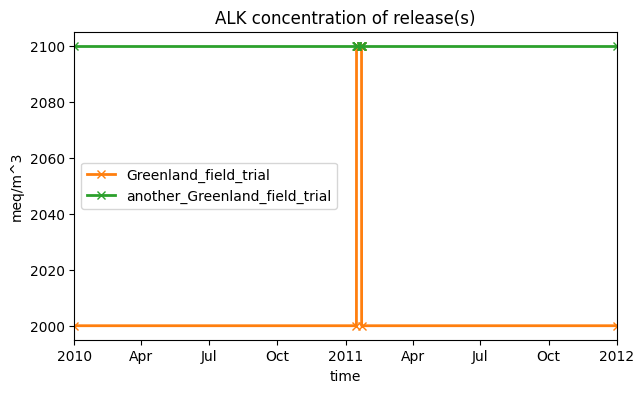

In [26]:
cdr_forcing.plot_tracer_concentration(
    "ALK", releases=["Greenland_field_trial", "another_Greenland_field_trial"]
)

At first glance, the figures above may seem to show unexpected behavior. However, this behavior is explained by the following reasoning:

<div class="alert alert-info">

Important

ROMS requires volume fluxes and tracer concentrations for the entire simulation period. The values are linearly interpolated between the provided time points. If the user does not specify the simulation's start and end points in their time series, `ROMS-Tools` will apply the following defaults:

* Volume flux is set to 0 at both the start and end times.
* Tracer concentrations at the start and end times are set to the values from the closest available time stamps.

</div>

### Auto-fill vs. Zero-fill

As mentioned earlier in the notebook, ROMS requires concentrations for all 32 BGC tracers, along with temperature and salinity, for CDR volume point sources. However, you may not have values for all of these tracers. To handle such cases, you can use the `fill_values` parameter to specify how to set the default values for any missing tracers:

- `fill_values = "auto"` (default): Automatically uses non-zero default values for any tracer concentrations that are not specified.
- `fill_values = "zero"`: Sets missing tracer concentrations to zero.

Since `fill_values = "auto"` is the default, this is the setting we've used in all previous releases. Now, let's create a plot to visualize the DIC and PO4 concentrations.

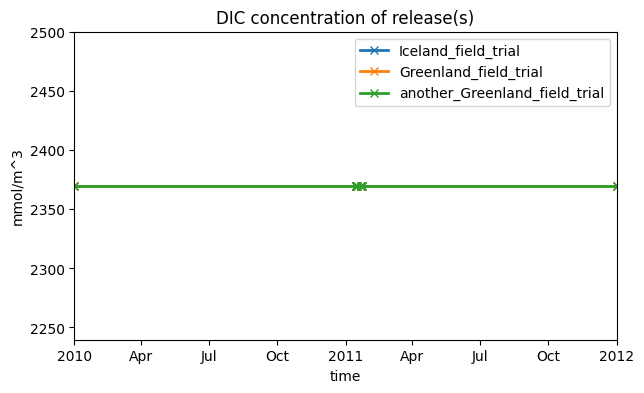

In [27]:
cdr_forcing.plot_tracer_concentration("DIC")

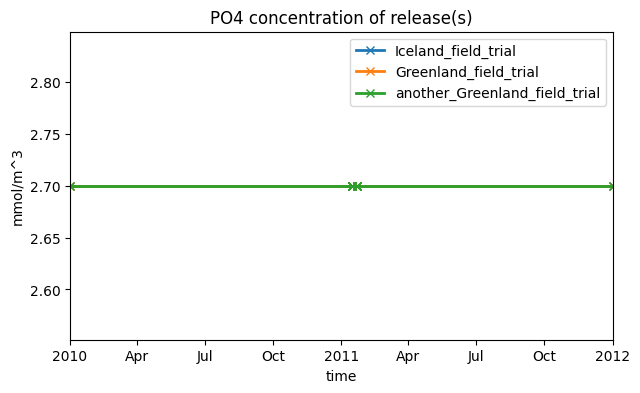

In [28]:
cdr_forcing.plot_tracer_concentration("PO4")

The default values (used with `fill_values = "auto"`) for DIC and PO4 are 2370.0 mmol/m³ and 2.7 mmol/m³, respectively, as confirmed by the figures. These values are also reflected in both the `.ds` and `.releases` attributes.

Next, let's use the `fill_values = "zero"` option to set missing values to zero for tracers that are not explicitly specified.

In [29]:
cdr_forcing.add_release(
    name="Greenland_field_trial_with_zero_fill",
    **greenland_params,
    volume_fluxes=1000,
    tracer_concentrations={"temp": 20.0, "salt": 1.0, "ALK": 2000.0},
    fill_values="zero",
)

The next two figures confirm that the missing tracer concentrations for the latest release (red line) were filled with zero, as expected when using the `fill_values = "zero"` option.

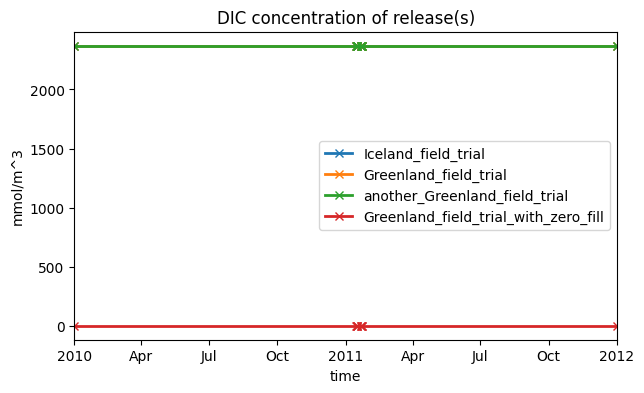

In [30]:
cdr_forcing.plot_tracer_concentration("DIC")

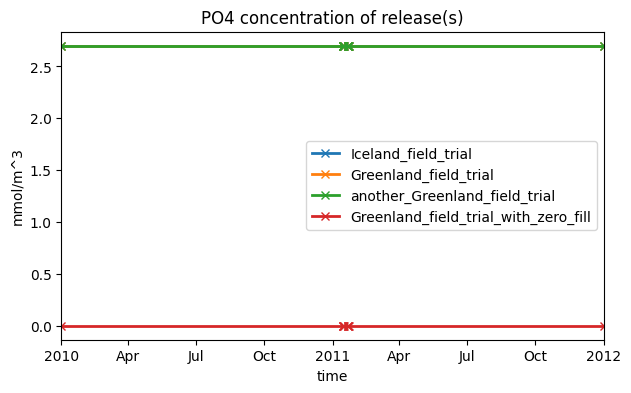

In [31]:
cdr_forcing.plot_tracer_concentration("PO4")

### Saving as NetCDF or YAML file

We can now save our CDR forcing data as a NetCDF file using the `.save` method. This file will include the dataset held by `.ds`, which contains the four releases we've defined. The resulting NetCDF file can then be used as input for ROMS simulations.

In [32]:
cdr_forcing.ds

<xarray.Dataset> Size: 21kB
Dimensions:           (time: 10, ntracers: 34, ncdr: 4)
Coordinates:
  * time              (time) datetime64[ns] 80B 2010-01-01 ... 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U36 576B 'Iceland_field_trial' ... 'Greenland_f...
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 80B 3.653e+03 4.032e+03 ... 4.383e+03
    cdr_lon           (ncdr) float64 32B -25.0 -20.0 -20.0 -20.0
    cdr_lat           (ncdr) float64 32B 65.0 70.0 70.0 70.0
    cdr_dep           (ncdr) float64 32B 10.0 100.0 100.0 100.0
    cdr_hsc           (ncdr) float64 32B 0.0 0.0 0.0 0.0
    cdr_vsc           (ncdr) float64 32B 0.0 0.0 0.0 0.0
    cdr_volume        (time, ncdr) float64 320B 1e+03 0.0 0.0 ... 0.0 0.0 1e+03
    cdr_tracer        (time, ntracers, ncdr) float64 11kB 20.0 20.0 ... 0.0

In [33]:
filepath = "/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc"

In [34]:
cdr_forcing.save(filepath=filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc


[PosixPath('/pscratch/sd/n/nloose/forcing/my_cdr_forcing.nc')]

We can also export the CDR forcing parameters and their associated release information to a YAML file.

In [35]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_cdr_forcing.yaml"

In [36]:
cdr_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [37]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()


# Print the contents
print(file_contents)

---
roms_tools_version: 2.6.3.dev4+g73c836f.d20250429
---
Grid:
  nx: 250
  ny: 250
  size_x: 2500
  size_y: 2500
  center_lon: -15
  center_lat: 65
  rot: -30
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
CDRVolumePointSource:
  start_time: '2010-01-01T00:00:00'
  end_time: '2012-01-01T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  releases:
    _tracer_metadata:
      temp:
        units: degrees Celsius
        long_name: potential temperature
      salt:
        units: PSU
        long_name: salinity
      PO4:
        units: mmol/m^3
        long_name: dissolved inorganic phosphate
      NO3:
        units: mmol/m^3
        long_name: dissolved inorganic nitrate
      SiO3:
        units: mmol/m^3
        long_name: dissolved inorganic silicate
      NH4:
        units: mmol/m^3
        long_name: dissolved ammonia
      Fe:
        units: mmol/m

### Creating a CDR volume point source from an existing YAML file

Once we have the YAML file containing the CDR forcing parameters and release information, we can use it to recreate the exact same CDR volume point source.

In [38]:
the_same_cdr_forcing = CDRVolumePointSource.from_yaml(yaml_filepath)

The dataset contained in the `.ds` attribute already includes the same four releases as before, so there's no need to manually re-add them.

In [39]:
the_same_cdr_forcing.ds

<xarray.Dataset> Size: 21kB
Dimensions:           (time: 10, ntracers: 34, ncdr: 4)
Coordinates:
  * time              (time) datetime64[ns] 80B 2010-01-01 ... 2012-01-01
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    release_name      (ncdr) <U36 576B 'Iceland_field_trial' ... 'Greenland_f...
Dimensions without coordinates: ntracers, ncdr
Data variables:
    cdr_time          (time) float64 80B 3.653e+03 4.032e+03 ... 4.383e+03
    cdr_lon           (ncdr) float64 32B -25.0 -20.0 -20.0 -20.0
    cdr_lat           (ncdr) float64 32B 65.0 70.0 70.0 70.0
    cdr_dep           (ncdr) float64 32B 10.0 100.0 100.0 100.0
    cdr_hsc           (ncdr) float64 32B 0.0 0.0 0.0 0.0
    cdr_vsc           (ncdr) float64 32B 0.0 0.0 0.0 0.0
    cdr_volume        (time, ncdr) float64 320B 1e+03 0.0 0.0 ... 0.0 0.0 1e+03
    cdr_tracer        (time, ntracers, ncdr) float64 11kB 20.0 20.0 ... 0.0

## CDR Tracer Perturbation

Coming soon...